In [1]:
import pyupbit
import pandas as pd
from dotenv import load_dotenv
import os
from datetime import datetime, timedelta
import datetime as dt
import time

# 데이터 수집

In [4]:
load_dotenv()

access_key = os.environ['access_key']
secret_key = os.environ['secret_key']

# 업비트 객체 생성
upbit = pyupbit.Upbit(access_key, secret_key)


In [5]:
# 보유 잔액 확인
balances = upbit.get_balances(contain_req=True)
print("보유 자산 목록:")
print(balances)

# 비트코인 현재 가격 조회
price = pyupbit.get_current_price("KRW-BTC")
print(f"현재 비트코인 가격: {price}원")


보유 자산 목록:
([], {'group': 'default', 'min': 1800, 'sec': 29})
현재 비트코인 가격: 161202000.0원


In [32]:
t = pd.to_datetime(datetime.now()) - timedelta(minutes=10)

t = "2017-09-25 12:05:00"
t = "2025-08-18 00:00:00"
t = pd.to_datetime(t, format='%Y-%m-%d %H:%M:%S') - timedelta(hours=9)
t = t.strftime('%Y-%m-%d %H:%M:00')

df = pyupbit.get_ohlcv(ticker="KRW-BTC", interval="minute1", count=5, to=t)
print(df)

                            open         high          low        close  \
2025-08-17 23:55:00  163530000.0  163536000.0  163520000.0  163520000.0   
2025-08-17 23:56:00  163520000.0  163520000.0  163510000.0  163511000.0   
2025-08-17 23:57:00  163511000.0  163511000.0  163504000.0  163505000.0   
2025-08-17 23:58:00  163505000.0  163505000.0  163500000.0  163501000.0   
2025-08-17 23:59:00  163501000.0  163525000.0  163500000.0  163505000.0   

                       volume         value  
2025-08-17 23:55:00  0.371821  6.080245e+07  
2025-08-17 23:56:00  0.340388  5.565761e+07  
2025-08-17 23:57:00  0.255730  4.181414e+07  
2025-08-17 23:58:00  1.110321  1.815386e+08  
2025-08-17 23:59:00  0.585600  9.575024e+07  


In [ ]:
import pyupbit
import pandas as pd
from datetime import datetime, timedelta
import time
from tqdm import tqdm  # tqdm 라이브러리를 가져옵니다.

print("데이터 수집을 시작합니다...")

now = pd.to_datetime("2025-08-18 00:00:00", format='%Y-%m-%d %H:%M:%S')
# now = pd.to_datetime("2017-09-25 12:10:00", format='%Y-%m-%d %H:%M:%S')
coin = "KRW-BTC" # KRW-BTC, KRW-ETH, KRW-XRP

# --- 설정 ---
# days_to_collect = 1825
# target_date = now - timedelta(days=days_to_collect)
target_date = pd.to_datetime("2017-09-25 00:00:00", format='%Y-%m-%d %H:%M:%S')
days_to_collect = (now - target_date).days
count_per_request = 200

# --- 중간 저장을 위한 설정 ---
save_interval = 100  # 100번의 요청마다 중간 저장
loop_count = 0
output_dir = "./data/"
output_filepath = f"{output_dir}{coin[-3:]}_data_all.csv"

# --- tqdm을 위한 전체 진행량 계산 ---
# 30일은 총 몇 분인지 계산합니다. (1분봉 기준)
total_minutes = days_to_collect * 24 * 60

# --- 데이터 수집 ---
all_df = pd.DataFrame()
to_time = now

# tqdm을 with 문과 함께 사용하여 루프가 끝나면 자동으로 정리되도록 합니다.
with tqdm(total=total_minutes, desc="1분봉 데이터 수집") as pbar:
    while True:
        try:
            df = pyupbit.get_ohlcv(ticker=coin, interval="minute1", count=count_per_request, to=(to_time - timedelta(hours=9)).strftime('%Y-%m-%d %H:%M:00'))

            if df is None or df.empty:
                print("\n더 이상 가져올 데이터가 없거나 API 응답이 없습니다.")
                break

            all_df = pd.concat([df, all_df])
            loop_count += 1
            
            pbar.update(len(df))
            oldest_time_in_df = df.index[0]
            pbar.set_description(f"수집 시점: {oldest_time_in_df.strftime('%Y-%m-%d %H:%M')}")

            # --- 중간 저장 로직 ---
            if loop_count % save_interval == 0:
                # 중복 데이터 제거 및 정렬 후 저장
                temp_df = all_df.drop_duplicates().sort_index()
                print(f"\n[{loop_count}번째 요청] 중간 저장 진행... ({output_filepath})")
                temp_df.to_csv(output_filepath, encoding='utf-8-sig')
                print(f"저장 완료. 현재까지 데이터 {len(temp_df)}개")

            if oldest_time_in_df <= target_date:
                print(f"\n목표 날짜({target_date.strftime('%Y-%m-%d')}) 이전 데이터에 도달하여 수집을 완료합니다.")
                break
                
            to_time = oldest_time_in_df
            time.sleep(0.1)
        
        except Exception as e:
            print(f"\n오류 발생: {e}. 5초 후 재시도합니다.")
            time.sleep(5)


# --- 데이터 후처리 및 최종 저장 ---
print("\n--- 최종 데이터 정리 및 저장 ---")
if not all_df.empty:
    final_df = all_df.drop_duplicates().sort_index()
    # 수집 루프에서 target_date 이전 데이터까지 포함되었을 수 있으므로 필터링
    final_df = final_df[final_df.index >= target_date]
    final_df.to_csv(output_filepath, encoding='utf-8-sig')
else:
    final_df = all_df

print("\n--- 최종 수집된 데이터 ---")
if not final_df.empty:
    print(f"수집된 데이터 개수: {len(final_df)}개")
    print(f"데이터 기간: {final_df.index[0]} ~ {final_df.index[-1]}")
    print("\n가장 오래된 데이터:")
    print(final_df.head(1))
    print("\n가장 최신 데이터:")
    print(final_df.tail(1))
else:
    print("수집된 데이터가 없습니다.")

print(f"\n모든 데이터가 성공적으로 '{output_filepath}'에 저장되었습니다.")


수집 시점: 2018-01-17 17:50:  95%|█████████▌| 3960000/4152960 [1:54:21<02:57, 1085.96it/s]


[19800번째 요청] 중간 저장 진행... (./data/BTC_1min_data_all.csv)


수집 시점: 2018-01-17 17:50:  95%|█████████▌| 3960000/4152960 [1:54:33<02:57, 1085.96it/s]

저장 완료. 현재까지 데이터 3959607개


수집 시점: 2018-01-03 19:57:  96%|█████████▌| 3980000/4152960 [1:55:11<02:45, 1047.27it/s]


[19900번째 요청] 중간 저장 진행... (./data/BTC_1min_data_all.csv)


수집 시점: 2018-01-03 19:57:  96%|█████████▌| 3980000/4152960 [1:55:23<02:45, 1047.27it/s]

저장 완료. 현재까지 데이터 3979607개


수집 시점: 2017-12-20 19:29:  96%|█████████▋| 4000000/4152960 [1:55:59<02:27, 1038.94it/s]


[20000번째 요청] 중간 저장 진행... (./data/BTC_1min_data_all.csv)


수집 시점: 2017-12-20 19:29:  96%|█████████▋| 4000000/4152960 [1:56:13<02:27, 1038.94it/s]

저장 완료. 현재까지 데이터 3999607개


수집 시점: 2017-12-06 15:55:  97%|█████████▋| 4020000/4152960 [1:56:48<02:09, 1024.41it/s]


[20100번째 요청] 중간 저장 진행... (./data/BTC_1min_data_all.csv)


수집 시점: 2017-12-06 15:55:  97%|█████████▋| 4020000/4152960 [1:57:03<02:09, 1024.41it/s]

저장 완료. 현재까지 데이터 4019607개


수집 시점: 2017-11-22 17:34:  97%|█████████▋| 4040000/4152960 [1:57:38<01:50, 1026.50it/s]


[20200번째 요청] 중간 저장 진행... (./data/BTC_1min_data_all.csv)


수집 시점: 2017-11-22 17:34:  97%|█████████▋| 4040000/4152960 [1:57:53<01:50, 1026.50it/s]

저장 완료. 현재까지 데이터 4039607개


수집 시점: 2017-11-08 18:34:  98%|█████████▊| 4060000/4152960 [1:58:28<01:32, 1002.15it/s]


[20300번째 요청] 중간 저장 진행... (./data/BTC_1min_data_all.csv)


수집 시점: 2017-11-08 18:34:  98%|█████████▊| 4060000/4152960 [1:58:44<01:32, 1002.15it/s]

저장 완료. 현재까지 데이터 4059607개


수집 시점: 2017-10-24 17:14:  98%|█████████▊| 4080000/4152960 [1:59:18<01:11, 1015.83it/s]


[20400번째 요청] 중간 저장 진행... (./data/BTC_1min_data_all.csv)


수집 시점: 2017-10-24 17:14:  98%|█████████▊| 4080000/4152960 [1:59:34<01:11, 1015.83it/s]

저장 완료. 현재까지 데이터 4079399개


수집 시점: 2017-10-04 04:49:  99%|█████████▊| 4100000/4152960 [2:00:08<00:53, 995.79it/s] 


[20500번째 요청] 중간 저장 진행... (./data/BTC_1min_data_all.csv)


수집 시점: 2017-10-04 04:49:  99%|█████████▊| 4100000/4152960 [2:00:24<00:53, 995.79it/s]

저장 완료. 현재까지 데이터 4099356개


수집 시점: 2017-09-25 12:00:  99%|█████████▉| 4111158/4152960 [2:00:49<01:13, 567.07it/s] 



더 이상 가져올 데이터가 없거나 API 응답이 없습니다.

--- 최종 데이터 정리 및 저장 ---

--- 최종 수집된 데이터 ---
수집된 데이터 개수: 4110499개
데이터 기간: 2017-09-25 12:00:00 ~ 2025-08-17 23:59:00

가장 오래된 데이터:
                          open       high        low      close    volume  \
2017-09-25 12:00:00  4201000.0  4220000.0  4195000.0  4216000.0  3.811221   

                            value  
2017-09-25 12:00:00  1.603785e+07  

가장 최신 데이터:
                            open         high          low        close  \
2025-08-17 23:59:00  163501000.0  163525000.0  163500000.0  163505000.0   

                     volume         value  
2025-08-17 23:59:00  0.5856  9.575024e+07  

모든 데이터가 성공적으로 './data/BTC_1min_data_all.csv'에 저장되었습니다.


In [ ]:
import yfinance as yf
import pandas as pd

interval = "1h"

# S&P 500 데이터 다운로드 (티커: ^GSPC)
# period="730d": 최근 730일간의 데이터
# interval="60m": 60분(1시간) 봉 단위
sp500_data = yf.download(tickers="^GSPC", period="91d", interval=interval)

# 나스닥 종합지수 데이터 다운로드 (티커: ^IXIC)
nasdaq_data = yf.download(tickers="^IXIC", period="91d", interval=interval)

# 금 선물
gold_data = yf.download(tickers="GC=F", period="100d", interval=interval)

# 달러 인덱스
dollar_data = yf.download(tickers="DX-Y.NYB", period="100d", interval=interval)


# 다운로드한 데이터를 CSV 파일로 저장
sp500_data.to_csv(f"sp500_{interval}_data.csv")
nasdaq_data.to_csv(f"nasdaq_{interval}_data.csv")
gold_data.to_csv(f"Gold_{interval}_data.csv")
dollar_data.to_csv(f"Dollar_{interval}_data.csv")

C:\Users\endermaru\AppData\Local\Temp\ipykernel_35804\3705927807.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_data = yf.download(tickers="GC=F", period="100d", interval=interval)
[*********************100%***********************]  1 of 1 completed
C:\Users\endermaru\AppData\Local\Temp\ipykernel_35804\3705927807.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dollar_data = yf.download(tickers="DX-Y.NYB", period="100d", interval=interval)
[*********************100%***********************]  1 of 1 completed


# 데이터 전처리

### 1분봉

In [ ]:
start_date = '2025-05-12 00:00:00'
end_date = '2025-08-09 23:59:00'

# 1분 단위의 DatetimeIndex를 생성하고, 'Asia/Seoul' 시간대를 설정합니다.
date_range_index = pd.date_range(start=start_date, end=end_date, freq='min')

# 생성된 인덱스를 사용하여 빈 DataFrame을 만듭니다.
df_coin = pd.DataFrame(index=date_range_index)
df_coin.head()

df_btc = pd.read_csv("./data/BTC_1min_data.csv", index_col=0, parse_dates=True)[['open','high','low','close','volume']]
df_btc.columns = 'btc_' + df_btc.columns

df_eth = pd.read_csv("./data/ETH_1min_data.csv", index_col=0, parse_dates=True)[['open','high','low','close','volume']]
df_eth.columns = 'eth_' + df_eth.columns

df_xrp = pd.read_csv("./data/XRP_1min_data.csv", index_col=0, parse_dates=True)[['open','high','low','close','volume']]
df_xrp.columns = 'xrp_' + df_xrp.columns

df_coin = pd.concat([df_coin, df_btc, df_eth, df_xrp], axis=1)

df_coin.index.name = 'Datetime'

# df = df[df.index >= pd.to_datetime("2025-05-13 00:00:00")]
df_coin.head()

,btc_open,btc_high,btc_low,btc_close,btc_volume,eth_open,eth_high,eth_low,eth_close,eth_volume,xrp_open,xrp_high,xrp_low,xrp_close,xrp_volume
Datetime,,,,,,,,,,,,,,,
2025-05-12 00:00:00,145676000.0,145677000.0,145626000.0,145677000.0,0.374630,3477000.0,3479000.0,3474000.0,3478000.0,6.891271,3302.0,3302.0,3299.0,3301.0,18793.671558
2025-05-12 00:01:00,145677000.0,145700000.0,145623000.0,145623000.0,0.188528,3478000.0,3482000.0,3478000.0,3478000.0,9.746652,3301.0,3302.0,3300.0,3301.0,10688.836095
2025-05-12 00:02:00,145625000.0,145700000.0,145620000.0,145623000.0,0.728360,3480000.0,3482000.0,3479000.0,3482000.0,9.372693,3301.0,3306.0,3301.0,3305.0,24399.604280
2025-05-12 00:03:00,145695000.0,145700000.0,145624000.0,145693000.0,0.281259,3480000.0,3485000.0,3479000.0,3485000.0,12.685174,3306.0,3306.0,3302.0,3304.0,7223.902515
2025-05-12 00:04:00,145693000.0,145755000.0,145693000.0,145755000.0,0.861492,3485000.0,3493000.0,3485000.0,3491000.0,29.567548,3304.0,3310.0,3304.0,3310.0,57426.118510


In [ ]:
df_dollar = pd.read_csv("./data/Dollar_1h_data.csv", index_col=0, parse_dates=True, header = 0, skiprows = [1,2])
df_gold = pd.read_csv("./data/Gold_1h_data.csv", index_col=0, parse_dates=True, header = 0, skiprows = [1,2])
df_nasdaq = pd.read_csv("./data/Nasdaq_1h_data.csv", index_col=0, parse_dates=True, header = 0, skiprows = [1,2])
df_sp500 = pd.read_csv("./data/SP500_1h_data.csv", index_col=0, parse_dates=True, header = 0, skiprows = [1,2])


for _df, _ticker in zip([df_dollar, df_gold, df_nasdaq, df_sp500], ['dollar', 'gold', 'nasdaq', 'sp500']):
    _df.index.name = 'Datetime'
    _df.columns = _ticker + '_' + _df.columns.str.lower()

df_others = pd.concat([df_dollar, df_gold, df_nasdaq, df_sp500], axis=1)

df_others.index = df_others.index.tz_convert('Asia/Seoul')
df_others.index = df_others.index.tz_localize(None)
# df_others = df_others[df_others.index >= df_coin.index[0]]

# df_others.head()

df_total = pd.concat([df_coin, df_others], axis=1)

# 거래량은 NaN값 별도 처리
volume_cols = ['nasdaq_volume', 'sp500_volume']

# 장중 시간 정의
start_time = dt.time(22, 30)
end_time = dt.time(5, 0)
is_trading_hours = (df_total.index.time >= start_time) | (df_total.index.time <= end_time)

# 비거래 시간(~is_trading_hours)에 해당하는 volume 컬럼의 NaN 값을 0으로 먼저 채우기
df_total.loc[~is_trading_hours, volume_cols] = df_total.loc[~is_trading_hours, volume_cols].fillna(0)

# 나머지 NaN값은 ffill 처리
df_total = df_total.fillna(method='ffill')

df_total = df_total[(df_total.index >= pd.to_datetime(start_date)) & (df_total.index <= pd.to_datetime(end_date))]

print(df_total.head())
df_total.to_csv("./data/data.csv", encoding='utf-8-sig')



C:\Users\endermaru\AppData\Local\Temp\ipykernel_16572\3295662030.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_total = df_total.fillna(method='ffill')


                        btc_open     btc_high      btc_low    btc_close  \
Datetime                                                                  
2025-05-12 00:00:00  145676000.0  145677000.0  145626000.0  145677000.0   
2025-05-12 00:01:00  145677000.0  145700000.0  145623000.0  145623000.0   
2025-05-12 00:02:00  145625000.0  145700000.0  145620000.0  145623000.0   
2025-05-12 00:03:00  145695000.0  145700000.0  145624000.0  145693000.0   
2025-05-12 00:04:00  145693000.0  145755000.0  145693000.0  145755000.0   

                     btc_volume   eth_open   eth_high    eth_low  eth_close  \
Datetime                                                                      
2025-05-12 00:00:00    0.374630  3477000.0  3479000.0  3474000.0  3478000.0   
2025-05-12 00:01:00    0.188528  3478000.0  3482000.0  3478000.0  3478000.0   
2025-05-12 00:02:00    0.728360  3480000.0  3482000.0  3479000.0  3482000.0   
2025-05-12 00:03:00    0.281259  3480000.0  3485000.0  3479000.0  3485000.0   


# 훈련

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

import joblib

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data.csv", index_col=0, parse_dates=True)
df = pd.read_csv("./data/data.csv", index_col=0, parse_dates=True)

In [ ]:
print(df.columns)
print(df.index.min(), df.index.max())
print(df.shape)

df.head()

Index(['btc_open', 'btc_high', 'btc_low', 'btc_close', 'btc_volume',
       'eth_open', 'eth_high', 'eth_low', 'eth_close', 'eth_volume',
       'xrp_open', 'xrp_high', 'xrp_low', 'xrp_close', 'xrp_volume',
       'dollar_close', 'dollar_high', 'dollar_low', 'dollar_open',
       'dollar_volume', 'gold_close', 'gold_high', 'gold_low', 'gold_open',
       'gold_volume', 'nasdaq_close', 'nasdaq_high', 'nasdaq_low',
       'nasdaq_open', 'nasdaq_volume', 'sp500_close', 'sp500_high',
       'sp500_low', 'sp500_open', 'sp500_volume'],
      dtype='object')
2025-05-12 00:00:00 2025-08-09 23:59:00
(129600, 35)


,btc_open,btc_high,btc_low,btc_close,btc_volume,eth_open,eth_high,eth_low,eth_close,eth_volume,...,nasdaq_close,nasdaq_high,nasdaq_low,nasdaq_open,nasdaq_volume,sp500_close,sp500_high,sp500_low,sp500_open,sp500_volume
Datetime,,,,,,,,,,,,,,,,,,,,,
2025-05-12 00:00:00,145676000.0,145677000.0,145626000.0,145677000.0,0.374630,3477000.0,3479000.0,3474000.0,3478000.0,6.891271,...,17925.759766,17953.833984,17920.0625,17943.357422,641874000.0,5659.149902,5667.169922,5657.399902,5665.669922,360615000.0
2025-05-12 00:01:00,145677000.0,145700000.0,145623000.0,145623000.0,0.188528,3478000.0,3482000.0,3478000.0,3478000.0,9.746652,...,17925.759766,17953.833984,17920.0625,17943.357422,641874000.0,5659.149902,5667.169922,5657.399902,5665.669922,360615000.0
2025-05-12 00:02:00,145625000.0,145700000.0,145620000.0,145623000.0,0.728360,3480000.0,3482000.0,3479000.0,3482000.0,9.372693,...,17925.759766,17953.833984,17920.0625,17943.357422,641874000.0,5659.149902,5667.169922,5657.399902,5665.669922,360615000.0
2025-05-12 00:03:00,145695000.0,145700000.0,145624000.0,145693000.0,0.281259,3480000.0,3485000.0,3479000.0,3485000.0,12.685174,...,17925.759766,17953.833984,17920.0625,17943.357422,641874000.0,5659.149902,5667.169922,5657.399902,5665.669922,360615000.0
2025-05-12 00:04:00,145693000.0,145755000.0,145693000.0,145755000.0,0.861492,3485000.0,3493000.0,3485000.0,3491000.0,29.567548,...,17925.759766,17953.833984,17920.0625,17943.357422,641874000.0,5659.149902,5667.169922,5657.399902,5665.669922,360615000.0


In [20]:
import seaborn as sns

# 상관관계 행렬 계산
corr_matrix = df.corr()

# btc_close와의 상관관계만 확인
print(corr_matrix['btc_close'].sort_values(ascending=False))

btc_close        1.000000
btc_high         0.999975
btc_low          0.999972
btc_open         0.999958
xrp_low          0.910827
xrp_close        0.910781
xrp_open         0.910762
xrp_high         0.910711
eth_low          0.902794
eth_close        0.902763
eth_open         0.902737
eth_high         0.902716
nasdaq_open      0.745701
nasdaq_high      0.743802
nasdaq_low       0.740012
nasdaq_close     0.738576
sp500_open       0.726673
sp500_high       0.722996
sp500_low        0.718046
sp500_close      0.715791
gold_close       0.286439
gold_low         0.285633
gold_high        0.281830
gold_open        0.279277
xrp_volume       0.212137
eth_volume       0.112980
btc_volume       0.071852
nasdaq_volume    0.024340
sp500_volume     0.015669
gold_volume     -0.010679
dollar_close    -0.179577
dollar_high     -0.180180
dollar_open     -0.180644
dollar_low      -0.182010
dollar_volume         NaN
Name: btc_close, dtype: float64


In [21]:
# 각 자산의 종가를 기준으로 예측
features = ['btc_close', 'eth_close', 'xrp_close', 'dollar_close', 'gold_close', 'nasdaq_close', 'sp500_close']

df = df[features]
df.head()

,btc_close,eth_close,xrp_close,dollar_close,gold_close,nasdaq_close,sp500_close
Datetime,,,,,,,
2025-05-12 00:00:00,145677000.0,3478000.0,3301.0,100.424004,3329.100098,17925.759766,5659.149902
2025-05-12 00:01:00,145623000.0,3478000.0,3301.0,100.424004,3329.100098,17925.759766,5659.149902
2025-05-12 00:02:00,145623000.0,3482000.0,3305.0,100.424004,3329.100098,17925.759766,5659.149902
2025-05-12 00:03:00,145693000.0,3485000.0,3304.0,100.424004,3329.100098,17925.759766,5659.149902
2025-05-12 00:04:00,145755000.0,3491000.0,3310.0,100.424004,3329.100098,17925.759766,5659.149902


In [23]:
# 정규화 - MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

print("정규화 완료. 데이터의 처음 5개:")
print(scaled_data[:5])

정규화 완료. 데이터의 처음 5개:
[[0.28539021 0.17828371 0.27351916 0.73004474 0.52102639 0.
  0.        ]
 [0.28356188 0.17828371 0.27351916 0.73004474 0.52102639 0.
  0.        ]
 [0.28356188 0.17968476 0.27526132 0.73004474 0.52102639 0.
  0.        ]
 [0.28593195 0.18073555 0.27482578 0.73004474 0.52102639 0.
  0.        ]
 [0.28803115 0.18283713 0.27743902 0.73004474 0.52102639 0.
  0.        ]]


In [ ]:
# import numpy as np
# from tensorflow.keras.utils import Sequence

# class DataGenerator(Sequence):
#     def __init__(self, data, seq_length, batch_size):
#         self.data = data
#         self.seq_length = seq_length
#         self.batch_size = batch_size

#     def __len__(self):
#         # 전체 데이터에서 생성 가능한 배치의 총 개수
#         return int(np.floor(len(self.data) - self.seq_length) / self.batch_size)

#     def __getitem__(self, idx):
#         # 주어진 인덱스(idx)에 해당하는 배치 1개를 생성
#         batch_start = idx * self.batch_size
#         batch_end = batch_start + self.batch_size

#         batch_xs = []
#         batch_ys = []

#         for i in range(batch_start, batch_end):
#             # 시퀀스 데이터와 타겟 데이터 생성
#             x = self.data[i : i + self.seq_length]
#             y = self.data[i + self.seq_length, 0] # 타겟은 btc_close
#             batch_xs.append(x)
#             batch_ys.append(y)
        
#         return np.array(batch_xs), np.array(batch_ys)

# # 파라미터 설정
# SEQUENCE_LENGTH = 1440
# BATCH_SIZE = 32 # 한 번에 32개의 시퀀스를 학습

# # 훈련/검증 데이터 분리 (제너레이터에 전달할 데이터)
# train_split = int(len(scaled_data) * 0.8)
# val_split = int(len(scaled_data) * 0.9)

# train_data = scaled_data[:train_split]
# val_data = scaled_data[train_split:val_split]
# test_data = scaled_data[val_split:]


# # 제너레이터 생성
# train_generator = DataGenerator(train_data, SEQUENCE_LENGTH, BATCH_SIZE)
# val_generator = DataGenerator(val_data, SEQUENCE_LENGTH, BATCH_SIZE)
# # test_generator = DataGenerator(test_data, SEQUENCE_LENGTH, BATCH_SIZE) # 필요시

# # 모델 훈련 시 제너레이터를 사용
# model.fit(train_generator, validation_data=val_generator, epochs=50)

In [24]:
# 시퀀스 데이터 생성
def create_sequences_with_horizon(data, seq_length, future_horizon):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - future_horizon + 1):
        x = data[i:i + seq_length]  # 입력(X)은 seq_length 만큼의 모든 변수 데이터
        y = data[i + seq_length + future_horizon - 1, 0] # 정답(y)은 seq_length + future_horizon - 1 번째의 첫 번째 변수(btc_close)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# 시퀀스 길이 설정
SEQUENCE_LENGTH = 120 # 2시간
FUTURE_HORIZON = 30   # 1시간
X, y = create_sequences_with_horizon(scaled_data, SEQUENCE_LENGTH, FUTURE_HORIZON)

print(f"X 데이터 형태: {X.shape}") # (샘플 수, 시퀀스 길이, feature 수)
print(f"y 데이터 형태: {y.shape}") # (샘플 수, feature 수)

X 데이터 형태: (129451, 120, 7)
y 데이터 형태: (129451,)


In [25]:
# 훈련, 검증, 테스트 데이터 분리
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]

print(f"훈련 데이터: {X_train.shape}, {y_train.shape}")
print(f"검증 데이터: {X_val.shape}, {y_val.shape}")
print(f"테스트 데이터: {X_test.shape}, {y_test.shape}")

훈련 데이터: (103560, 120, 7), (103560,)
검증 데이터: (12945, 120, 7), (12945,)
테스트 데이터: (12946, 120, 7), (12946,)


In [28]:
# 사용된 변수의 개수
num_features = X.shape[2]

# Bidirectional LSTM 모델
model = Sequential([
    Input(shape=(SEQUENCE_LENGTH, num_features)),
    Bidirectional(LSTM(units=50, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=50, return_sequences=False)),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 120, 100)       │        23,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 120, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,151 (336.53 KB)

 Trainable params: 86,151 (336.53 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 모델 컴파일, 훈련
model.compile(optimizer='adam', loss='mean_squared_error')

# 조기 종료 및 최적 모델 저장 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(f'./lstm/btc_price_model_{FUTURE_HORIZON}.h5', monitor='val_loss', save_best_only=True)

# 모델 훈련
history = model.fit(
    X_train, y_train,
    epochs=100, # 최대 100번 반복 학습
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1 # 학습 과정 출력
)

print("모델 훈련이 완료되었습니다.")

# Scaler 저장
joblib.dump(scaler, './lstm/btc_price_scaler.pkl')

Epoch 1/100
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0040

3237/3237 ━━━━━━━━━━━━━━━━━━━━ 181s 55ms/step - loss: 0.0012 - val_loss: 3.7470e-04
Epoch 2/100
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 203s 63ms/step - loss: 3.4721e-04 - val_loss: 0.0017
Epoch 3/100
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 3.3517e-04

3237/3237 ━━━━━━━━━━━━━━━━━━━━ 199s 62ms/step - loss: 3.2272e-04 - val_loss: 9.3138e-05
Epoch 4/100
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 199s 61ms/step - loss: 3.0298e-04 - val_loss: 1.5646e-04
Epoch 5/100
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 159s 49ms/step - loss: 2.9988e-04 - val_loss: 7.4610e-04
Epoch 6/100
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 131s 40ms/step - loss: 2.9157e-04 - val_loss: 9.8050e-05
Epoch 7/100
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 161s 50ms/step - loss: 2.7707e-04 - val_loss: 7.0473e-04
Epoch 8/100
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 189s 59ms/step - loss: 2.6845e-04 - val_loss: 1.9438e-04
Epoch 9/100
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 197s 61ms/step - loss: 2.6333e-04 - val_loss: 2.5077e-04
Epoch 10/100
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 2.6979e-04

3237/3237 ━━━━━━━━━━━━━━━━━━━━ 190s 59ms/step - loss: 2.6386e-04 - val_loss: 5.6728e-05
Epoch 11/100
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 188s 58ms/step - loss: 2.5340e-04 - val_loss: 9.3547e-05
Epoch 12/100
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 193s 60ms/step - loss: 2.5697e-04 - val_loss: 2.6744e-04
Epoch 13/100
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 210s 65ms/step - loss: 2.4872e-04 - val_loss: 5.7529e-05
Epoch 14/100
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 188s 58ms/step - loss: 2.5037e-04 - val_loss: 1.4897e-04
Epoch 15/100
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 192s 59ms/step - loss: 2.4564e-04 - val_loss: 1.3490e-04
Epoch 16/100
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 195s 60ms/step - loss: 2.4016e-04 - val_loss: 2.4722e-04
Epoch 17/100
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 199s 61ms/step - loss: 2.4051e-04 - val_loss: 1.9878e-04
Epoch 18/100
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 198s 61ms/step - loss: 2.3814e-04 - val_loss: 1.1131e-04
Epoch 19/100
3237/3237 ━━━━━━━━━━━━━━━━━━━━ 199s 62ms/step - loss: 2.3780e-04 - val_loss: 1.1155e-04
Epo

405/405 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
테스트 데이터셋의 최종 RMSE: 175193.05


C:\Users\endermaru\AppData\Local\Temp\ipykernel_40848\2813001627.py:36: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.savefig('btc_prediction_result.png') # 그래프를 이미지 파일로 저장
C:\Users\endermaru\AppData\Local\Temp\ipykernel_40848\2813001627.py:36: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  plt.savefig('btc_prediction_result.png') # 그래프를 이미지 파일로 저장
C:\Users\endermaru\AppData\Local\Temp\ipykernel_40848\2813001627.py:36: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.savefig('btc_prediction_result.png') # 그래프를 이미지 파일로 저장
C:\Users\endermaru\AppData\Local\Temp\ipykernel_40848\2813001627.py:36: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.savefig('btc_prediction_result.png') # 그래프를 이미지 파일로 저장
C:\Users\endermaru\AppData\Local\Temp\ipykernel_40848\2813001627.py:36: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) mi


예측 결과 그래프가 'btc_prediction_result.png' 파일로 저장되었습니다.


d:\desktop\wafflestudio\hasha\coin\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\desktop\wafflestudio\hasha\coin\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


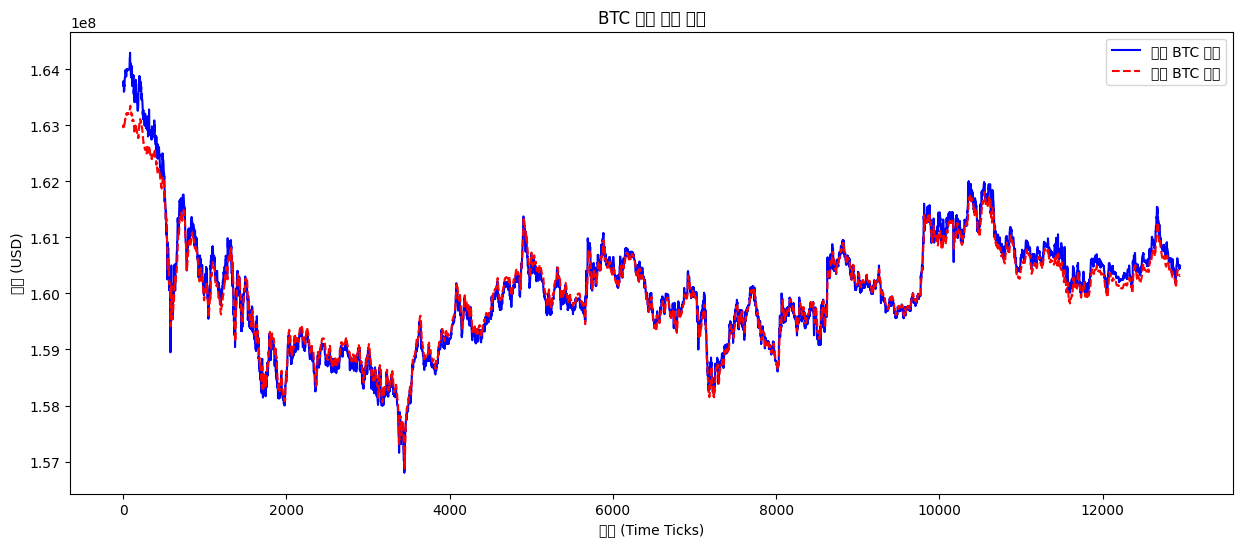

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib

FUTURE_HORIZON = 30 # 학습 시와 동일한 값으로 설정
saved_model = load_model(f'./lstm/btc_price_model_{FUTURE_HORIZON}.h5')
scaler = joblib.load('./lstm/btc_price_scaler.pkl')

# --- RMSE 계산 (이 부분은 이전과 동일) ---
predictions_scaled = saved_model.predict(X_test)

temp_for_predictions = np.zeros((len(predictions_scaled), num_features))
temp_for_predictions[:, 0] = predictions_scaled.flatten()
predictions = scaler.inverse_transform(temp_for_predictions)[:, 0]

temp_for_y_test = np.zeros((len(y_test), num_features))
temp_for_y_test[:, 0] = y_test.flatten()
y_test_unscaled = scaler.inverse_transform(temp_for_y_test)[:, 0]

rmse = np.sqrt(np.mean((predictions - y_test_unscaled)**2))
print(f"테스트 데이터셋의 최종 RMSE: {rmse:.2f}")


# --- ✅ 결과 시각화 ---

# 1. 실제 가격 흐름 전체를 가져옵니다.
# y_test_unscaled는 미래 값들의 목록이므로, 실제 비트코인 가격 컬럼을 직접 사용합니다.
features = ['btc_close', 'eth_close', 'xrp_close', 'dollar_close', 'gold_close', 'nasdaq_close', 'sp500_close']
test_len = test_len = int(df.shape[0] * 0.1)
test_data_actual_price = df[features]['btc_close'][-test_len:].values


# 2. 예측값을 실제 시간 축에 맞게 배치할 '그림판'을 준비합니다.
# 실제 가격과 길이가 같고, 비어있는(NaN) 배열을 만듭니다.
plot_predictions = np.full(len(test_data_actual_price), np.nan)

# 3. '그림판'의 올바른 위치에 예측값을 채워 넣습니다.
# X_test의 각 샘플 i는 (i + SEQUENCE_LENGTH) 시점에서 (i + SEQUENCE_LENGTH + FUTURE_HORIZON - 1) 시점을 예측한 것입니다.
# 이 예측값을 해당 미래 시점의 인덱스에 넣습니다.
for i, pred in enumerate(predictions):
    # 예측이 적용될 미래 시점의 인덱스를 계산
    prediction_index = i + SEQUENCE_LENGTH + FUTURE_HORIZON - 1

    # 해당 인덱스가 그림판 범위 안에 있을 경우에만 값을 채웁니다.
    if prediction_index < len(plot_predictions):
        plot_predictions[prediction_index] = pred

# 4. 그래프를 그립니다.
plt.figure(figsize=(15, 6))
# 실제 가격 흐름을 파란색 실선으로 그립니다.
plt.plot(test_data_actual_price, color='blue', label='BTC Price', zorder=1)
# 예측 가격을 빨간색 점 또는 짧은 선으로 그립니다.
plt.plot(plot_predictions, color='red', label=f'Predicted price in {FUTURE_HORIZON}min', linestyle='--', marker='o', markersize=3, zorder=2)

plt.title(f'BTC Price Prediction ({FUTURE_HORIZON}minutes)')
plt.xlabel('Time Ticks')
plt.ylabel('USD')
plt.legend()
plt.grid(True)
# plt.savefig('btc_prediction_result_horizon.png')
# print("\n예측 결과 그래프가 'btc_prediction_result_horizon.png' 파일로 저장되었습니다.")
plt.show()

# 예측

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import joblib

# --- 1. 예측 환경 설정 (가장 중요한 부분) ---
SEQUENCE_LENGTH = 120  # 모델 학습 시와 동일한 시퀀스 길이
FUTURE_HORIZON = 30    # 🎯 예측하고 싶은 미래 시점 (분). 1분 뒤를 예측하려면 1로 설정.

# --- 2. 모델 및 데이터 로드 ---

# 설정한 FUTURE_HORIZON에 맞는 모델을 동적으로 불러옵니다.
# (모델 파일 이름이 'best_btc_model_horizon_60.h5'와 같은 형식이라고 가정)
model_path = f'./lstm/btc_price_model_{FUTURE_HORIZON}.h5'
print(f"'{model_path}' 모델을 로드합니다...")
loaded_model = load_model(model_path)
loaded_scaler = joblib.load('./lstm/btc_price_scaler.pkl')

# 데이터 로드
df = pd.read_csv("./data/data.csv", index_col=0, parse_dates=True)
features_to_use = ['btc_close', 'eth_close', 'xrp_close', 'dollar_close', 'gold_close', 'nasdaq_close', 'sp500_close']
df = df[features_to_use] # 학습 때 사용한 변수만 선택
num_features = len(features_to_use)

# --- 3. 새로운 데이터 준비 ---
# ✅ .values 제거: DataFrame을 그대로 사용하여 Scikit-learn 경고를 방지하고 안전성을 높임
new_data_raw = df[-SEQUENCE_LENGTH:]

# 데이터가 충분한지 확인
if len(new_data_raw) < SEQUENCE_LENGTH:
    print(f"오류: 예측에 필요한 데이터 길이({SEQUENCE_LENGTH})보다 데이터가 부족합니다.")
else:
    # --- 4. 데이터 정규화 ---
    new_data_scaled = loaded_scaler.transform(new_data_raw)

    # --- 5. 모델 입력 형태로 변경 ---
    new_data_input = np.reshape(new_data_scaled, (1, SEQUENCE_LENGTH, num_features))

    # --- 6. 가격 예측 ---
    new_prediction_scaled = loaded_model.predict(new_data_input, verbose=0)

    # --- 7. 예측 결과 역변환 ---
    temp_for_prediction = np.zeros((1, num_features))
    temp_for_prediction[:, 0] = new_prediction_scaled.flatten()
    new_prediction = loaded_scaler.inverse_transform(temp_for_prediction)[:, 0]

    print("---")
    # ✅ 최종 출력 메시지를 FUTURE_HORIZON에 맞게 수정
    print(f"현재 시점 기준, {FUTURE_HORIZON}분 뒤 BTC 예측 가격: {new_prediction[0]:.2f} USD")

# 백테스팅

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tqdm import tqdm
import joblib

# --- ✅ 1. 설정의 유연성 및 명확성 확보 ---
# 이 섹션에서 모든 파라미터를 관리합니다.

SEQUENCE_LENGTH = 120    # 모델 학습 시 사용한 시퀀스 길이
FUTURE_HORIZON = 30       # 예측할 미래 시점 (분). 1분 뒤 모델은 1, 60분 뒤 모델은 60
FEE_RATE = 0.0005        # 거래 수수료 (예: 0.05%)
BUY_THRESHOLD = 0.001    # 현재가 대비 0.1% 이상 상승 예측 시 매수
SELL_THRESHOLD = 0.001   # 현재가 대비 0.1% 이상 하락 예측 시 매도

# --- 2. 모델 및 데이터 준비 ---

# 설정값에 따라 모델과 데이터를 동적으로 준비합니다.
if FUTURE_HORIZON == 1:
    model_path = './lstm/btc_price_model.h5' # 1분 예측 모델 이름
else:
    model_path = f'./lstm/btc_price_model_{FUTURE_HORIZON}.h5'

print(f"'{model_path}' 모델을 로드합니다...")
model = load_model(model_path)
scaler = joblib.load('./lstm/btc_price_scaler.pkl')

df = pd.read_csv("./data/data.csv", index_col=0, parse_dates=True)
# ✅ 학습에 사용한 변수 목록을 명확히 정의
features_to_use = ['btc_close', 'eth_close', 'xrp_close', 'dollar_close', 'gold_close', 'nasdaq_close', 'sp500_close']
df = df[features_to_use]
num_features = len(features_to_use)

test_len = int(df.shape[0] * 0.1)
backtest_data_raw = df[-test_len:].copy()

# 초기 자본금 설정
initial_capital = 1000000
cash = initial_capital
btc_held = 0

portfolio_history = []
transaction_log = []

print("--- 백테스팅 시작 ---")
print(f"초기 자본: {initial_capital:,.0f}원")

# --- 3. 시뮬레이션 루프 ---

for i in tqdm(range(len(backtest_data_raw) - SEQUENCE_LENGTH - 1)):
    input_sequence_raw = backtest_data_raw.iloc[i : i + SEQUENCE_LENGTH]
    current_price = backtest_data_raw.iloc[i + SEQUENCE_LENGTH]['btc_close']
    
    input_sequence_scaled = scaler.transform(input_sequence_raw)
    input_model = np.reshape(input_sequence_scaled, (1, SEQUENCE_LENGTH, num_features))
    prediction_scaled = model.predict(input_model, verbose=0)
    
    temp_array = np.zeros((1, num_features))
    temp_array[:, 0] = prediction_scaled.flatten()
    predicted_price = scaler.inverse_transform(temp_array)[:, 0][0]

    # ✅ 4. 현실적인 매매 전략 및 거래 비용 반영 ---
    
    # 매수 조건: 예측 가격이 현재가보다 'BUY_THRESHOLD' 이상 오를 것 같고, 현금이 있을 때
    if predicted_price > current_price * (1 + BUY_THRESHOLD) and cash > 0:
        # 수수료를 제외하고 살 수 있는 BTC 수량 계산
        btc_to_buy = (cash / current_price) * (1 - FEE_RATE)
        btc_held += btc_to_buy
        cash = 0
        transaction_log.append(f"시점 {i}: 매수 | 가격: {current_price:,.0f} | 수량: {btc_to_buy:.4f}")
        
    # 매도 조건: 예측 가격이 현재가보다 'SELL_THRESHOLD' 이상 내릴 것 같고, 보유한 BTC가 있을 때
    elif predicted_price < current_price * (1 - SELL_THRESHOLD) and btc_held > 0:
        # 수수료를 제외하고 받게 될 현금 계산
        cash = (btc_held * current_price) * (1 - FEE_RATE)
        btc_held = 0
        transaction_log.append(f"시점 {i}: 매도 | 가격: {current_price:,.0f} | 실현금액: {cash:,.0f}원")
    
    # 그 외의 경우 (매수/매도 조건 사이의 '중립 구간')는 아무것도 하지 않음 (Hold)
    
    current_portfolio_value = cash + (btc_held * current_price)
    portfolio_history.append(current_portfolio_value)

# --- 5. 결과 분석 및 시각화 ---
# (이 부분은 이전 코드와 동일)

if not portfolio_history:
    print("\n거래가 한 번도 발생하지 않았습니다.")
else:
    final_portfolio_value = portfolio_history[-1]
    profit = final_portfolio_value - initial_capital
    profit_rate = (profit / initial_capital) * 100

    print("\n--- 백테스팅 종료 ---")
    for log in transaction_log[:5]:
        print(log)
    if len(transaction_log) > 5: print("...")

    print(f"\n최종 자산: {final_portfolio_value:,.0f}원")
    print(f"총 손익: {profit:,.0f}원")
    print(f"수익률: {profit_rate:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(portfolio_history, label='Portfolio Value', color='blue')
    plt.title('Improved Automated Trading Backtesting Results')
    plt.xlabel('Time (Time Ticks)')
    plt.ylabel('Portfolio Value (KRW)')
    plt.legend()
    plt.grid(True)
    plt.show()

--- 백테스팅 시작 ---
초기 자본: 1,000,000원


 29%|██▊       | 3283/11519 [07:55<19:53,  6.90it/s]  


KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tqdm import tqdm
import joblib

# --- ✅ 1. 설정 보강 ---
SEQUENCE_LENGTH = 120
FUTURE_HORIZON = 30
FEE_RATE = 0.0005
# ✅ 이동평균선 기간 설정
SHORT_MA_WINDOW = 20
LONG_MA_WINDOW = 60

# --- 2. 모델 및 데이터 준비 ---
if FUTURE_HORIZON == 1:
    model_path = './lstm/btc_price_model.h5'
else:
    model_path = f'./lstm/btc_price_model_{FUTURE_HORIZON}.h5'

print(f"'{model_path}' 모델을 로드합니다...")
model = load_model(model_path)
scaler = joblib.load('./lstm/btc_price_scaler.pkl')

df = pd.read_csv("./data/data.csv", index_col=0, parse_dates=True)
features_to_use = ['btc_close', 'eth_close', 'xrp_close', 'dollar_close', 'gold_close', 'nasdaq_close', 'sp500_close']
df = df[features_to_use]
num_features = len(features_to_use)

test_len = int(df.shape[0] * 0.1)
backtest_data_raw = df[-test_len:].copy()

# ✅ 이동평균선 계산
backtest_data_raw['short_ma'] = backtest_data_raw['btc_close'].rolling(window=SHORT_MA_WINDOW).mean()
backtest_data_raw['long_ma'] = backtest_data_raw['btc_close'].rolling(window=LONG_MA_WINDOW).mean()

# 초기 자본금 설정
initial_capital = 1000000
cash = initial_capital
btc_held = 0

portfolio_history = []
transaction_log = []

print("--- 백테스팅 시작 ---")
print(f"초기 자본: {initial_capital:,.0f}원")

# --- 3. 시뮬레이션 루프 ---
for i in tqdm(range(len(backtest_data_raw) - SEQUENCE_LENGTH - 1)):
    input_sequence_raw = backtest_data_raw.iloc[i : i + SEQUENCE_LENGTH]
    
    # ✅ 현재 시점을 t로 정의 (의사결정 시점)
    t = i + SEQUENCE_LENGTH
    current_price = backtest_data_raw.iloc[t]['btc_close']
    
    # ✅ 이동평균선 값 가져오기
    short_ma_current = backtest_data_raw['short_ma'].iloc[t]
    long_ma_current = backtest_data_raw['long_ma'].iloc[t]
    short_ma_prev = backtest_data_raw['short_ma'].iloc[t-1]
    long_ma_prev = backtest_data_raw['long_ma'].iloc[t-1]
    
    # ✅ 이동평균선이 계산되지 않은 초기 구간은 건너뜀
    if pd.isna(long_ma_current) or pd.isna(long_ma_prev):
        portfolio_history.append(cash + (btc_held * current_price))
        continue

    # LSTM 예측 (이 부분은 동일)
    input_sequence_scaled = scaler.transform(input_sequence_raw)
    input_model = np.reshape(input_sequence_scaled, (1, SEQUENCE_LENGTH, num_features))
    prediction_scaled = model.predict(input_model, verbose=0)
    
    temp_array = np.zeros((1, num_features))
    temp_array[:, 0] = prediction_scaled.flatten()
    predicted_price = scaler.inverse_transform(temp_array)[:, 0][0]

    # --- ✅ 4. 이평선 교차 + LSTM 확인 전략 ---
    
    # 신호 정의
    golden_cross = (short_ma_prev < long_ma_prev) and (short_ma_current > long_ma_current)
    dead_cross = (short_ma_prev > long_ma_prev) and (short_ma_current < long_ma_current)
    lstm_confirms_buy = predicted_price > current_price
    lstm_confirms_sell = predicted_price < current_price

    # 매수 조건: 골든 크로스 발생 + LSTM이 상승 예측 + 현금 보유
    if golden_cross and lstm_confirms_buy and cash > 0:
        btc_to_buy = (cash / current_price) * (1 - FEE_RATE)
        btc_held += btc_to_buy
        cash = 0
        transaction_log.append(f"시점 {t}: 매수 (골든크로스) | 가격: {current_price:,.0f}")
        
    # 매도 조건: 데드 크로스 발생 + LSTM이 하락 예측 + BTC 보유
    elif dead_cross and lstm_confirms_sell and btc_held > 0:
        cash = (btc_held * current_price) * (1 - FEE_RATE)
        btc_held = 0
        transaction_log.append(f"시점 {t}: 매도 (데드크로스) | 가격: {current_price:,.0f}")
    
    current_portfolio_value = cash + (btc_held * current_price)
    portfolio_history.append(current_portfolio_value)

# --- 5. 결과 분석 및 시각화 ---
# (이 부분은 이전 코드와 동일)

if not portfolio_history or not transaction_log:
    print("\n거래가 한 번도 발생하지 않았습니다.")
else:
    final_portfolio_value = portfolio_history[-1]
    profit = final_portfolio_value - initial_capital
    profit_rate = (profit / initial_capital) * 100

    print("\n--- 백테스팅 종료 ---")
    for log in transaction_log:
        print(log)

    print(f"\n최종 자산: {final_portfolio_value:,.0f}원")
    print(f"총 손익: {profit:,.0f}원")
    print(f"수익률: {profit_rate:.2f}%")

    plt.figure(figsize=(15, 6))
    plt.plot(portfolio_history, label='Portfolio Value', color='blue')
    plt.title('MA Crossover + LSTM Backtesting Results')
    plt.xlabel('Time (Time Ticks)')
    plt.ylabel('Portfolio Value (KRW)')
    plt.legend()
    plt.grid(True)
    plt.show()